In [172]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [173]:
stuff=np.load('sidebands.npz')
t=stuff['time']
d=stuff['signal']


In [174]:
def analytic_dev(p,t):
    
    y = p[0]/(1 + ((t - p[1])/p[2])**2)

    grad = np.zeros([t.size, p.size])

    grad[:,0] = 1.0/(1 + ((t - p[1])/p[2])**2)
    grad[:,1] = 2*p[0]*p[2]**2*(t-p[1])/((t - p[1])**2 + p[2]**2)**2
    grad[:,2] = 2*p[0]*p[2]*(t-p[1])**2/((t - p[1])**2 + p[2]**2)**2

    return y, grad

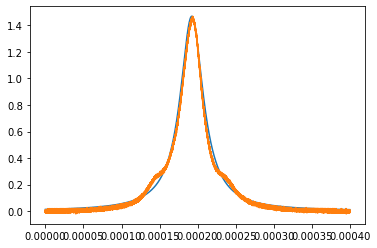

In [175]:
plt.plot(t,analytic_dev(np.array([max(d), 0.0001923, 0.0000185]),t)[0])
plt.plot(t,d)

[1.42113712e+00 1.92341699e-04 1.79752584e-05] 101.07114289253195
[1.42265692e+00 1.92357528e-04 1.79274442e-05] 63.70670195053774
[1.42279999e+00 1.92358562e-04 1.79239597e-05] 63.67283277258047
[1.42280990e+00 1.92358643e-04 1.79237105e-05] 63.67266320499407
[1.42281062e+00 1.92358649e-04 1.79236922e-05] 63.672662311918835
[1.42281068e+00 1.92358649e-04 1.79236909e-05] 63.67266230719842
[1.42281068e+00 1.92358649e-04 1.79236908e-05] 63.67266230717346
[1.42281068e+00 1.92358649e-04 1.79236908e-05] 63.67266230717334
[1.42281068e+00 1.92358649e-04 1.79236908e-05] 63.672662307173326
[1.42281068e+00 1.92358649e-04 1.79236908e-05] 63.672662307173326
[1.42281068e+00 1.92358649e-04 1.79236908e-05] 63.67266230717333
[1.42281068e+00 1.92358649e-04 1.79236908e-05] 63.67266230717333


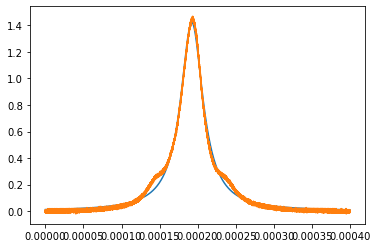

In [176]:
p0 = np.array([max(d), 0.0001923, 0.0000185])
p=p0.copy()
for j in range(12):
    pred,grad=analytic_dev(p,t)
    r=d-pred
    err=(r**2).sum()
    r=np.matrix(r).transpose()
    grad=np.matrix(grad)

    lhs=grad.transpose()*grad
    rhs=grad.transpose()*r
    dp=np.linalg.inv(lhs)*(rhs)
    for jj in range(p.size):
        p[jj]=p[jj]+dp[jj]
    print(p,err)
plt.plot(t,pred)
plt.plot(t,d)


In [177]:
N=np.mean((d - analytic_dev(p,t)[0])**2)
par_errs=np.sqrt(N*np.diag(np.linalg.inv(lhs)))
par_errs

array([4.25479046e-04, 5.35834556e-09, 7.58809724e-09])

In [178]:
def f(p,t):
    return p[0]/(1 + ((t - p[1])/p[2])**2)

In [179]:
def ndiff2(f,p,t):
    
    dx = t[1]-t[0]
    
    def T(f,p,t,i,dx):
        l = p.copy()
        l[i] += dx
        return f(l,t)

    grad = np.zeros([t.size, p.size])

    for i in range(p.size):
         grad[:,i] = (T(f,p,t,i,dx)-T(f,p,t,i,-dx))/(2*dx)

    return grad

[1.42113712e+00 1.92341699e-04 1.79752584e-05] 101.07114289253195
[1.42265692e+00 1.92357528e-04 1.79274442e-05] 63.70670195576228
[1.42279999e+00 1.92358562e-04 1.79239596e-05] 63.67283277283469
[1.42280990e+00 1.92358643e-04 1.79237105e-05] 63.67266320502382
[1.42281062e+00 1.92358649e-04 1.79236922e-05] 63.67266231192088
[1.42281068e+00 1.92358649e-04 1.79236909e-05] 63.67266230719859
[1.42281068e+00 1.92358649e-04 1.79236908e-05] 63.67266230717348
[1.42281068e+00 1.92358649e-04 1.79236908e-05] 63.67266230717335
[1.42281068e+00 1.92358649e-04 1.79236908e-05] 63.67266230717335
[1.42281068e+00 1.92358649e-04 1.79236908e-05] 63.67266230717335
[1.42281068e+00 1.92358649e-04 1.79236908e-05] 63.67266230717334
[1.42281068e+00 1.92358649e-04 1.79236908e-05] 63.67266230717333
[1.42281068e+00 1.92358649e-04 1.79236908e-05] 63.67266230717334
[1.42281068e+00 1.92358649e-04 1.79236908e-05] 63.67266230717335
[1.42281068e+00 1.92358649e-04 1.79236908e-05] 63.67266230717335
[1.42281068e+00 1.923586

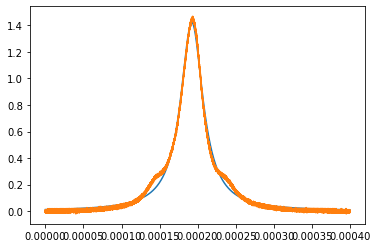

In [180]:
p0 = np.array([max(d), 0.0001923, 0.0000185])
p=p0.copy()
for j in range(20):
    pred =  f(p,t)
    grad = ndiff2(f,p,t)
    r=d-pred
    err=(r**2).sum()
    r=np.matrix(r).transpose()
    grad=np.matrix(grad)

    lhs=grad.transpose()*grad
    rhs=grad.transpose()*r
    dp=np.linalg.inv(lhs)*(rhs)
    for jj in range(p.size):
        p[jj]=p[jj]+dp[jj]
    print(p,err)
plt.plot(t,pred)
plt.plot(t,d)

In [181]:
def f2(p,t):
    lorentz1 = p[0]/(1 + ((t - p[1])/p[2])**2)
    lorentz2 = p[3]/(1 + ((t - (p[1]-p[4]))/p[2])**2)
    lorentz3 = p[5]/(1 + ((t - (p[1]+p[4]))/p[2])**2)
    return lorentz1+lorentz2+lorentz3

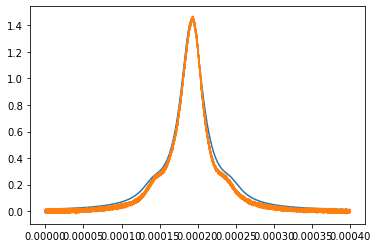

In [182]:
guess2 = np.array([1.42113712e+00, 1.92341699e-04, 1.79752584e-05, 0.1,
 5.1e-05, 0.1])
plt.plot(t,f2(guess2,t))
plt.plot(t,d)

[1.44051706e+00 1.92504117e-04 1.59921472e-05 9.88696908e-02
 4.42657394e-05 6.81362345e-02] 128.56792995507115
[1.44272942e+00 1.92579908e-04 1.60885286e-05 1.03308525e-01
 4.48028639e-05 6.38979157e-02] 21.850523345356336
[1.44303906e+00 1.92576987e-04 1.60601016e-05 1.03962295e-01
 4.45082687e-05 6.49864723e-02] 21.2589062108689
[1.44297951e+00 1.92578868e-04 1.60666109e-05 1.03886916e-01
 4.45832274e-05 6.46587697e-02] 21.24813017505862
[1.44299580e+00 1.92578423e-04 1.60647124e-05 1.03916660e-01
 4.45627711e-05 6.47520688e-02] 21.247337109306876
[1.44299146e+00 1.92578549e-04 1.60652184e-05 1.03909142e-01
 4.45683558e-05 6.47271575e-02] 21.247278852253647
[1.44299265e+00 1.92578515e-04 1.60650798e-05 1.03911226e-01
 4.45668385e-05 6.47339866e-02] 21.24727452986363
[1.44299233e+00 1.92578524e-04 1.60651175e-05 1.03910661e-01
 4.45672517e-05 6.47321323e-02] 21.247274209949204
[1.44299241e+00 1.92578521e-04 1.60651072e-05 1.03910815e-01
 4.45671393e-05 6.47326373e-02] 21.247274186226

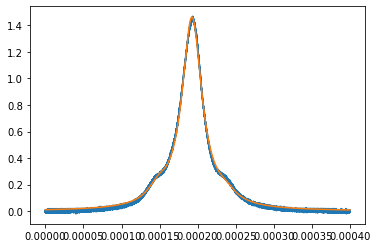

In [184]:
guess2 = np.array([1.42113712e+00, 1.92341699e-04, 1.79752584e-05, 0.1,
 5.1e-05, 0.1])
p=guess2.copy()
for j in range(20):
    pred =  f2(p,t)
    grad = ndiff2(f2,p,t)
    r=d-pred
    err=(r**2).sum()
    r=np.matrix(r).transpose()
    grad=np.matrix(grad)

    lhs=grad.transpose()*grad
    rhs=grad.transpose()*r
    dp=np.linalg.inv(lhs)*(rhs)
    for jj in range(p.size):
        p[jj]=p[jj]+dp[jj]
    print(p,err)
plt.plot(t,d)
plt.plot(t,pred)